In [1]:
import operator
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import numpy as np
import pandas as pd
from functools import partial
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("./merged.csv")

In [3]:
df.head()

,creates_hidden_file,Ransomware appends_extension,antivm_queries_computername,network service communication,create service,Generate Crypto Key,Create_exe,Network tor,antivm_memory_available,Peid Packer,...,call_count,compare_count,avg_betweenness_centrality,avg_closeness_centrality,avg_degree_centrality,avg_eigenvector_centrality,avg_pagerank,avg_katz_centrality,avg_clustering_coefficient,label
0,0,0,0,1,0,0,1,1,0,1,...,12,5,0.086746,0.380842,0.669048,0.262290,0.234127,0.470593,0.326111,1
1,0,0,0,1,0,0,1,1,0,1,...,12,5,0.086746,0.380842,0.669048,0.262290,0.234127,0.470593,0.326111,1
2,0,0,0,0,0,0,0,0,0,1,...,73,29,0.055437,0.259993,0.470586,0.258009,0.228742,0.443314,0.074205,1
3,0,0,0,0,0,0,1,0,0,1,...,60,19,0.057316,0.206434,0.330150,0.183187,0.149553,0.356481,0.084686,1
4,0,0,1,0,0,0,0,0,0,1,...,283,138,0.070114,0.216372,0.304646,0.164184,0.125465,0.325517,0.145345,1


In [4]:
X = df.iloc[:, :-1]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   creates_hidden_file            1194 non-null   int64  
 1   Ransomware appends_extension   1194 non-null   int64  
 2   antivm_queries_computername    1194 non-null   int64  
 3   network service communication  1194 non-null   int64  
 4   create service                 1194 non-null   int64  
 5   Generate Crypto Key            1194 non-null   int64  
 6   Create_exe                     1194 non-null   int64  
 7   Network tor                    1194 non-null   int64  
 8   antivm_memory_available        1194 non-null   int64  
 9   Peid Packer                    1194 non-null   int64  
 10  Persistance autorun            1194 non-null   int64  
 11  mov_count                      1194 non-null   int64  
 12  transfer_count                 1194 non-null   i

In [6]:
y = df.iloc[:, -1]

In [7]:
np.unique(y)

array([0, 1])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
print(X_train.shape, X_test.shape)

(895, 23) (299, 23)


In [10]:
print(y_train.shape, y_test.shape)

(895,) (299,)


In [11]:
def eaSimple(
    population,
    toolbox,
    cxpb,
    mutpb,
    ngen,
    stats=None,
    halloffame=None,
    verbose=__debug__,
    use_varAnd=True,
):
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        if use_varAnd:
            offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        else:
            offspring = algorithms.varOr(
                offspring, toolbox, len(offspring), cxpb, mutpb
            )

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [12]:
def evaluate(individual, toolbox):
    func = toolbox.compile(expr=individual)
    y_pred = [func(*data) for _, data in X_train.iterrows()]
    y_labels = np.unique(y)
    y_pred = list(map(lambda x: y_labels[0] if x > 0 else y_labels[1], y_pred))
    tmp = random.random()
    ret =  tmp * accuracy_score(y_train, y_pred) + (1 - tmp) * f1_score(
        y_train, y_pred
    )
    return ret,

In [13]:
# Use iloc instead of directly indexing like X[col][0] as the indices will shuffled during train_test_split
pset = gp.PrimitiveSetTyped("main", [type(X_train[col].iloc[0]) for col in X_train], np.float64, "IN")

In [14]:
def protected_div(left, right):
    if right != 0:
        return np.float64(left / right)
    else:
        return np.float64(1)
pset.addPrimitive(operator.add, [np.float64, np.float64], np.float64)
pset.addPrimitive(operator.sub, [np.float64, np.float64], np.float64)
pset.addPrimitive(operator.mul, [np.float64, np.float64], np.float64)
pset.addPrimitive(protected_div, [np.float64, np.float64], np.float64)
# Add this constant to prevent no primitive found error
# This occurs because there may be an odd number of inputs and all the functions are binary
pset.addEphemeralConstant(name="RAND", ephemeral=partial(np.float64, random.random()), ret_type=np.float64)

In [15]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

In [16]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [17]:
toolbox = base.Toolbox()

In [18]:
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=7)

In [19]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

In [20]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [21]:
toolbox.register("compile", gp.compile, pset=pset)

In [22]:
toolbox.register(
    "evaluate",
    evaluate,
    toolbox=toolbox,
)

In [23]:
toolbox.register("select", tools.selTournament, tournsize=6)

In [24]:
toolbox.register("mate", gp.cxOnePoint)

In [25]:
toolbox.register("expr_mut", gp.genFull, min_=2, max_=6)

In [26]:
toolbox.register("mutate", gp.mutShrink)
# toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [27]:
use_varAnd = True
cxpb = 0
mutpb = 1

In [28]:
pop = toolbox.population(100)

In [29]:
hof = tools.HallOfFame(1)

In [30]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

In [31]:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [32]:
pop, log = eaSimple(
    pop,
    toolbox,
    cxpb=cxpb,
    mutpb=mutpb,
    ngen=200,
    stats=stats,
    halloffame=hof,
    verbose=True,
    use_varAnd=use_varAnd
)

gen	nevals	avg     	std    	min      	max     
0  	100   	0.366032	0.17467	0.0114306	0.811136
1  	100   	0.39209 	0.186337	0.010706 	0.796595
2  	100   	0.383504	0.20243 	0.0191758	0.774093
3  	100   	0.372841	0.227003	0.0106375	0.816932
4  	100   	0.432579	0.232233	0.0255392	0.810178
5  	100   	0.377222	0.206494	0.0263126	0.807923
6  	100   	0.42586 	0.223574	0.0321597	0.804241
7  	100   	0.38329 	0.236381	0.0010441	0.804298
8  	100   	0.407492	0.219904	0.0254853	0.806225
9  	100   	0.384088	0.213895	0.00210424	0.780972
10 	100   	0.411801	0.216586	0.0308186 	0.801909
11 	100   	0.404174	0.221805	0.00580673	0.812241
12 	100   	0.394456	0.214107	0.0293478 	0.817851
13 	100   	0.432132	0.226251	0.00551401	0.817531
14 	100   	0.400987	0.228172	0.00406249	0.81312 
15 	100   	0.41151 	0.241907	0.00448846	0.815779
16 	100   	0.351336	0.231778	0.00781666	0.802408
17 	100   	0.433676	0.224921	0.00761306	0.812574
18 	100   	0.430121	0.214973	0.00772679	0.805869
19 	100   	0.4453  	0.240893	0.0

In [33]:
def test(individual, toolbox=toolbox):
    func = toolbox.compile(expr=individual)
    y_pred = [func(*data) for _, data in X_test.iterrows()]
    y_labels = np.unique(y)
    y_pred = list(map(lambda x: y_labels[0] if x > 0 else y_labels[1], y_pred))
    return accuracy_score(y_test, y_pred)

In [34]:
final_ind = hof[0]

In [35]:
test(final_ind)

0.8127090301003345

In [36]:
final_ind_graph= gp.graph(final_ind)

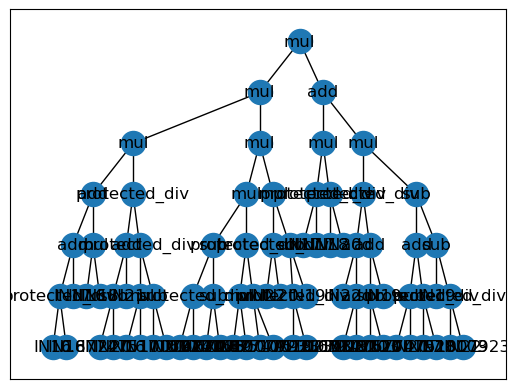

In [37]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

nodes, edges, labels = gp.graph(final_ind)

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [38]:
import pygraphviz as pgv

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")